# CF Car-Camera(with ALS)

### Initialization

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType,StructField, StringType, IntegerType,TimestampType

spark = SparkSession \
    .builder \
    .appName("Spark_Processor") \
    .master("local[*]") \
    .getOrCreate()

sc = spark.sparkContext

schema = StructType([ \
        StructField("DEVICE_CODE", IntegerType(), True), 
        StructField("SYSTEM_ID",IntegerType(),True), \
        StructField("ORIGINE_CAR_KEY",IntegerType(),True), \
        StructField("FINAL_CAR_KEY", IntegerType(),True), \
        StructField("CHECK_STATUS_KEY", IntegerType(), True), \
        StructField("COMPANY_ID", StringType(), True), \
        StructField("PASS_DAY_TIME", TimestampType(), True)
    ])

22/02/14 10:29:46 WARN Utils: Your hostname, amin-X556UQK resolves to a loopback address: 127.0.1.1; using 192.168.1.100 instead (on interface wlp3s0)
22/02/14 10:29:46 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/02/14 10:29:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
df = spark.read.csv('Traffic.csv',header=True,schema=schema)
df.show(1)

+-----------+---------+---------------+-------------+----------------+----------+-------------------+
|DEVICE_CODE|SYSTEM_ID|ORIGINE_CAR_KEY|FINAL_CAR_KEY|CHECK_STATUS_KEY|COMPANY_ID|      PASS_DAY_TIME|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+
|     200501|       81|       10477885|     10477885|               5|       161|2021-06-01 03:54:39|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+
only showing top 1 row



##### Remove 8th day

In [3]:
from pyspark.sql.functions import dayofyear
df = df.withColumn('day', dayofyear(df.PASS_DAY_TIME))
df = df.filter(df.day != 159)
df.show(1)

+-----------+---------+---------------+-------------+----------------+----------+-------------------+---+
|DEVICE_CODE|SYSTEM_ID|ORIGINE_CAR_KEY|FINAL_CAR_KEY|CHECK_STATUS_KEY|COMPANY_ID|      PASS_DAY_TIME|day|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+---+
|     200501|       81|       10477885|     10477885|               5|       161|2021-06-01 03:54:39|152|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+---+
only showing top 1 row



##### Remove Outliers

In [4]:
from pyspark.sql.functions import hour,dayofweek, count
from pyspark.sql.window import Window

window = Window.partitionBy('FINAL_CAR_KEY')
df_with_car_count = df.withColumn('count', count('FINAL_CAR_KEY').over(window))
df_cleaned = df_with_car_count.filter(df_with_car_count['count'] < 1000)
df_cleaned.show(5)

+-----------+---------+---------------+-------------+----------------+----------+-------------------+---+-----+
|DEVICE_CODE|SYSTEM_ID|ORIGINE_CAR_KEY|FINAL_CAR_KEY|CHECK_STATUS_KEY|COMPANY_ID|      PASS_DAY_TIME|day|count|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+---+-----+
|     803001|      102|        7631929|      7631929|               6|       161|2021-06-01 10:37:55|152|    1|
|   22010048|      284|        7631930|      7631930|               5|       161|2021-06-02 13:21:00|153|    1|
|     900158|      283|        7631979|      7631979|               5|       264|2021-06-06 12:30:50|157|    9|
|  100700881|      283|        7631979|      7631979|               5|       264|2021-06-06 17:46:08|157|    9|
|     900222|      283|        7631979|      7631979|               5|       264|2021-06-06 17:49:52|157|    9|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+---

In [ ]:
car_counts = df.groupBy('FINAL_CAR_KEY').count()
traffic_cars = car_counts.filter(car_counts['count'] < 1000).sort('count', ascending=False).select('FINAL_CAR_KEY').take(1000)
traffic_cars = [x.FINAL_CAR_KEY for x in traffic_cars]
df_new = df.filter(df.FINAL_CAR_KEY.isin(traffic_cars))
df_new.show(5)

In [ ]:
df_new_agg = df_new.groupBy('DEVICE_CODE', 'FINAL_CAR_KEY').count()
df_new_agg.show(1)

+-----------+-------------+-----+
|DEVICE_CODE|FINAL_CAR_KEY|count|
+-----------+-------------+-----+
|     203902|      8358717|  173|
+-----------+-------------+-----+
only showing top 1 row



<h5 dir="rtl">
 در این قسمت با استفاده از الگوریتم 
 ALS
 و داده‌ها، مدلی را آموزش می‌دهیم تا بتوانیم روش
 CF
 را اجرا کنیم. برای این منظور داده‌ها را به دو دسته‌ی آموزش و آزمون تقسیم می‌کنیم. 
</h5> 


In [ ]:
from pyspark.ml.recommendation import ALS

training, test = df_new_agg.randomSplit([0.9, 0.1])

als = ALS(
    maxIter = 5, 
    regParam = 0.01, 
    userCol = 'DEVICE_CODE', 
    itemCol = 'FINAL_CAR_KEY', 
    ratingCol = 'count',
    coldStartStrategy= 'drop')

model = als.fit(training)

<h5 dir="rtl">
 حال مدل را روی داده‌ی تست اجرا می‌کنیم، و خطای مجذور میانگین مربعات را به دست می‌آوریم. 
</h5> 


In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
predictions = model.transform(test)
predictions.show(5)
evaluator = RegressionEvaluator(
    metricName = 'rmse', 
    labelCol = 'count',
    predictionCol = 'prediction'
    )
rmse = evaluator.evaluate(predictions)
print('Root-mean-square error = ' + str(rmse))

+-----------+-------------+-----+-----------+
|DEVICE_CODE|FINAL_CAR_KEY|count| prediction|
+-----------+-------------+-----+-----------+
|        100|      7751027|    1|-0.14467195|
|        100|      7826265|    1|    1.97664|
|        100|      8282813|    4|  1.9738057|
|        100|      8546086|    1|  1.2593776|
|        100|      8549282|    1|  1.5125268|
+-----------+-------------+-----+-----------+
only showing top 5 rows



Root-mean-square error = 12.176548351446888


In [ ]:
user_recommendations = model.recommendForAllUsers(5)
movie_recommendations = model.recommendForAllItems(5)
user_recommendations.show()
movie_recommendations.show()

/home/amin/.local/share/virtualenvs/HW-QXNApxFg/lib/python3.9/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


+-----------+--------------------+
|DEVICE_CODE|     recommendations|
+-----------+--------------------+
|        100|[{43211832, 37.65...|
|        101|[{28621897, 40.01...|
|        102|[{43211832, 46.11...|
|        103|[{73138295, 39.85...|
|        104|[{23569393, 16.40...|
|        105|[{10849200, 46.32...|
|        107|[{12172272, 33.22...|
|        108|[{43211832, 51.09...|
|        109|[{79136468, 25.67...|
|        110|[{43211832, 72.20...|
|        111|[{73138295, 6.711...|
|        112|[{8358717, 37.999...|
|        113|[{8358717, 109.49...|
|        114|[{8358717, 293.50...|
|        115|[{79136468, 62.11...|
|        117|[{43211832, 113.2...|
|        118|[{8358717, 40.434...|
|        119|[{57533271, 105.6...|
|        120|[{35666712, 34.69...|
|        121|[{43211832, 70.99...|
+-----------+--------------------+
only showing top 20 rows



+-------------+--------------------+
|FINAL_CAR_KEY|     recommendations|
+-------------+--------------------+
|      7632644|[{100701269, 24.9...|
|      7632674|[{212701, 36.7274...|
|      7635415|[{22010099, 39.10...|
|      7638218|[{631781, 53.8278...|
|      7646099|[{631781, 17.0999...|
|      7652901|[{22010099, 24.00...|
|      7653336|[{100700910, 274....|
|      7656088|[{212701, 14.0552...|
|      7658231|[{22010031, 182.0...|
|      7660460|[{100700943, 42.6...|
|      7663314|[{212701, 16.6538...|
|      7663487|[{22010096, 50.52...|
|      7677846|[{212701, 17.3602...|
|      7679526|[{22010099, 33.70...|
|      7680036|[{212701, 183.226...|
|      7690501|[{212701, 41.3343...|
|      7692714|[{212701, 16.2281...|
|      7694100|[{22010031, 51.59...|
|      7701727|[{22010099, 219.6...|
|      7701806|[{22010099, 12.64...|
+-------------+--------------------+
only showing top 20 rows



<h5 dir="rtl">
 برای نمایش بهتر نتیجه‌ی الگوریتم، چند دوربین را به دلخواه انتخاب کردم و داده‌های تست را به آن‌ها محدود کردم. 
</h5> 


In [ ]:
camera_subset = test.filter(df_cleaned.DEVICE_CODE < 105)
camera_subset.show(5)

+-----------+-------------+-----+
|DEVICE_CODE|FINAL_CAR_KEY|count|
+-----------+-------------+-----+
|        100|      7751027|    1|
|        100|      7826265|    1|
|        100|      8282813|    4|
|        100|      8546086|    1|
|        100|      8549282|    1|
+-----------+-------------+-----+
only showing top 5 rows



<h5 dir="rtl">
 حال برای این چند دوربین خاص، به کمک مدل تعداد بار دیدن را حدس زدم. 
</h5> 


In [ ]:
prediction_subset = model.transform(camera_subset)
prediction_subset.show(5)

+-----------+-------------+-----+-----------+
|DEVICE_CODE|FINAL_CAR_KEY|count| prediction|
+-----------+-------------+-----+-----------+
|        100|      7751027|    1|-0.14467195|
|        100|      7826265|    1|    1.97664|
|        100|      8282813|    4|  1.9738057|
|        100|      8546086|    1|  1.2593776|
|        100|      8549282|    1|  1.5125268|
+-----------+-------------+-----+-----------+
only showing top 5 rows



<h5 dir="rtl">
 حال خروجی را به صورتی دراوردم که قابل نمایش باشد.  
</h5> 


In [ ]:
camera_predictions = prediction_subset.rdd.map(lambda x: (x.DEVICE_CODE, (
    x.FINAL_CAR_KEY,
    x['count'],
    x['prediction']
))).groupByKey().mapValues(list).collect()

<h5 dir="rtl">
 در این مرحله نیز نتایج را برای این چند دوربین خاص رسم کردم. خطوط قرمز رنگ مقادیر واقعی هستند و خطوط سیاه مقادیر پیش‌بینی شده. همانطوری که می‌بینید الگوریتم به خوبی توانسته است در زمان‌هایی که داده نداشته است، تعداد ثبت پلاک‌ها برای هر دوربین را پیش‌بینی کند. 
</h5> 


['7751027', '7826265', '8282813', '8546086', '8549282', '8573322', '8593809', '8620871', '8629218', '8696319', '9219523', '9555734', '10055466', '10579591', '10682485', '12163434', '13565906', '15914157', '17893130', '19686815', '20523455', '20660585', '23439088', '23571811', '23845669', '28621897', '7665666', '7678305', '7685000', '7722511', '7804917', '7837289', '8282689', '8412121', '8419614', '8548660', '8564092', '8584540', '8621361', '8682112', '9457148', '9507854', '10136130', '10210093', '14520610', '15295582', '16531138', '16580003', '21779685', '22132663', '23933461', '51468835', '51880996', '91958298']
[1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 4, 2, 1, 1, 1, 3, 1, 1, 1, 14, 1, 1, 2, 4, 1, 2, 3, 1, 3, 1, 2, 4, 18, 2, 3, 9, 4, 2, 1, 1, 1, 2, 1, 20, 2, 1, 1]
[-0.1446719467639923, 1.976639986038208, 1.9738056659698486, 1.2593775987625122, 1.5125267505645752, 1.739682674407959, 1.3073434829711914, 1.3617680072784424, 7.008552551269531, 1.3873041868209839, 1.996708273887

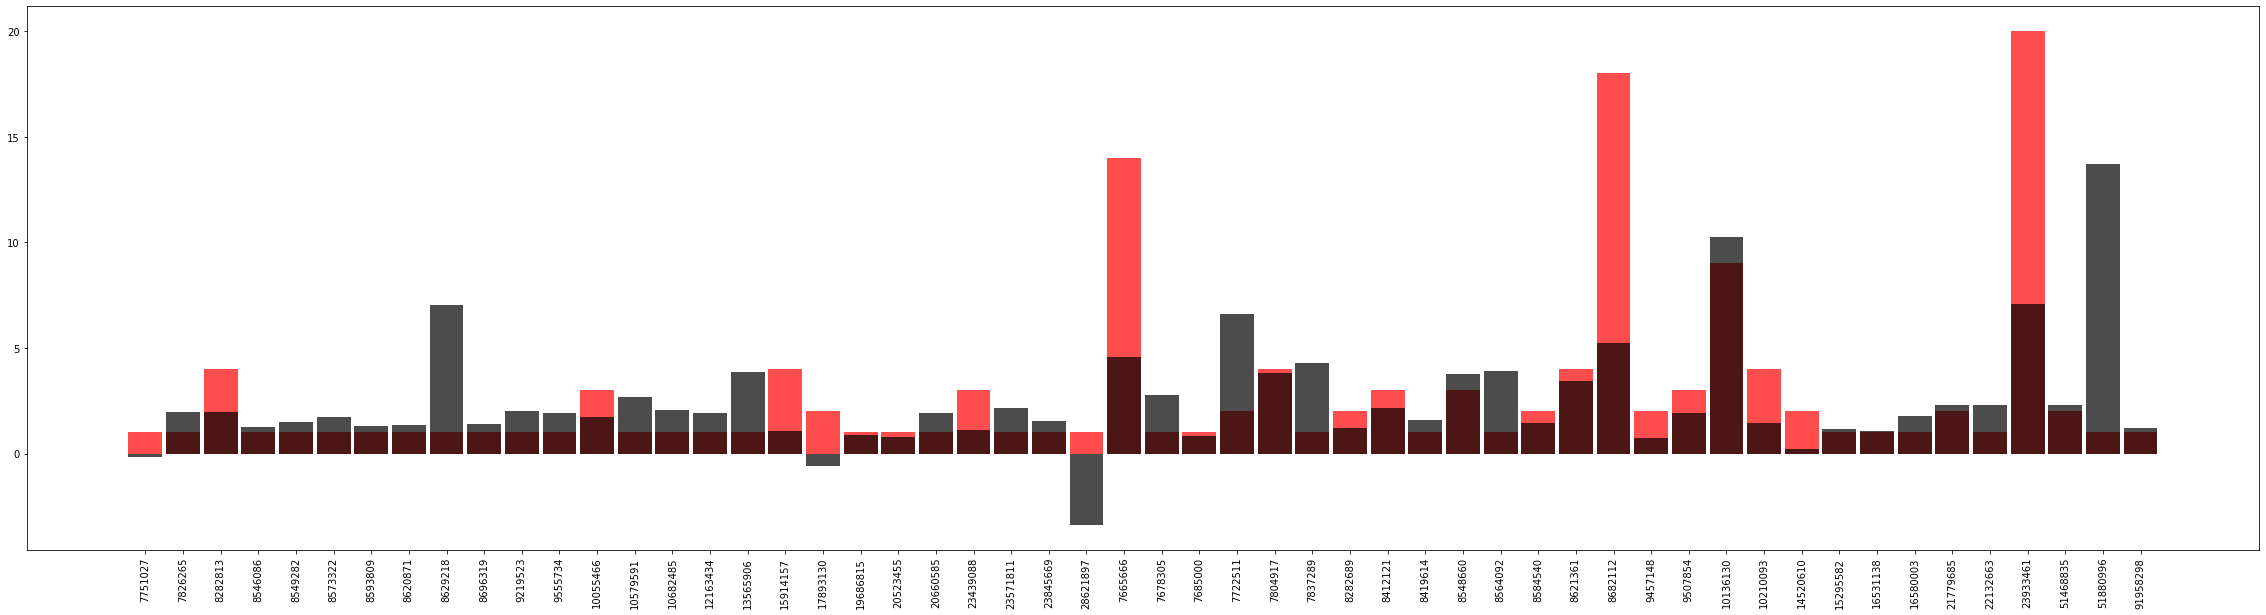

['8063460', '8593809', '9469799', '10812506', '78383517', '85604027', '7658202', '13311024', '96071352']
[5, 1, 4, 1, 1, 1, 1, 1, 1]
[2.308232069015503, 0.5968796610832214, 0.7791963815689087, 1.3291693925857544, 1.921768069267273, 0.7897987365722656, 0.7174561023712158, 2.212895631790161, 0.7766057848930359]


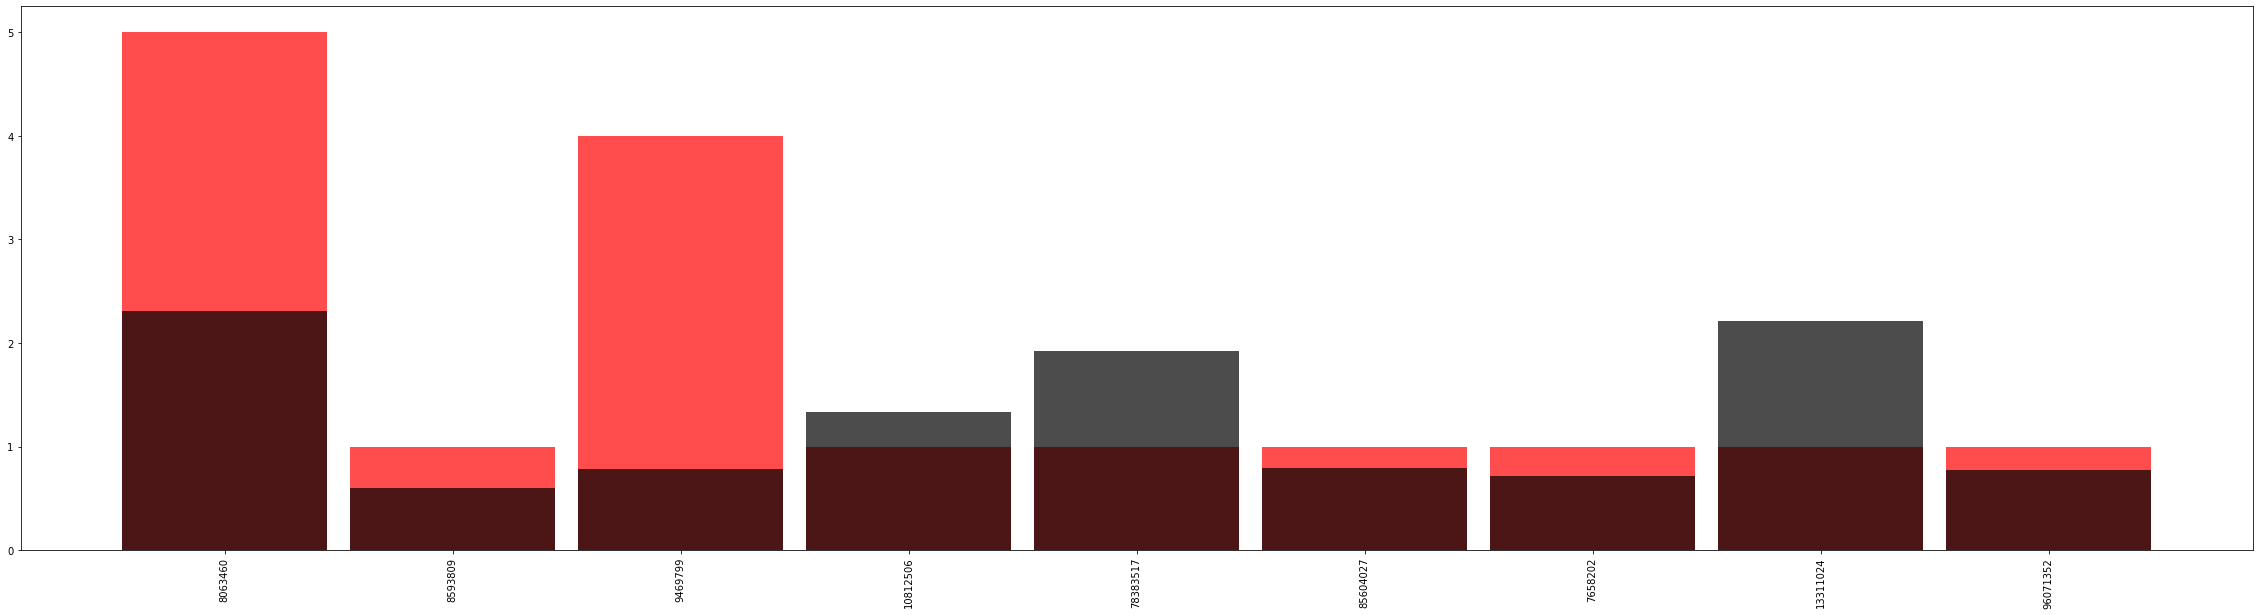

['7632644', '7761245', '7821233', '8593809', '9469799', '29485775', '29646009', '35804953', '61719863', '7795748', '8427961', '8453504', '8552026', '8799059', '17343446', '73389712', '75085858', '79143382', '79770805']
[2, 1, 1, 1, 2, 1, 5, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1]
[2.5257065296173096, 1.4743753671646118, 0.9943267703056335, 0.9426735639572144, 1.1410382986068726, 1.4816592931747437, 1.3538424968719482, 1.0826736688613892, 0.8433742523193359, 1.3813962936401367, 2.057239294052124, 1.152861475944519, 0.7303273677825928, 1.3672219514846802, 1.8835313320159912, 0.9401810169219971, 1.6350715160369873, 1.4255212545394897, 1.2073266506195068]


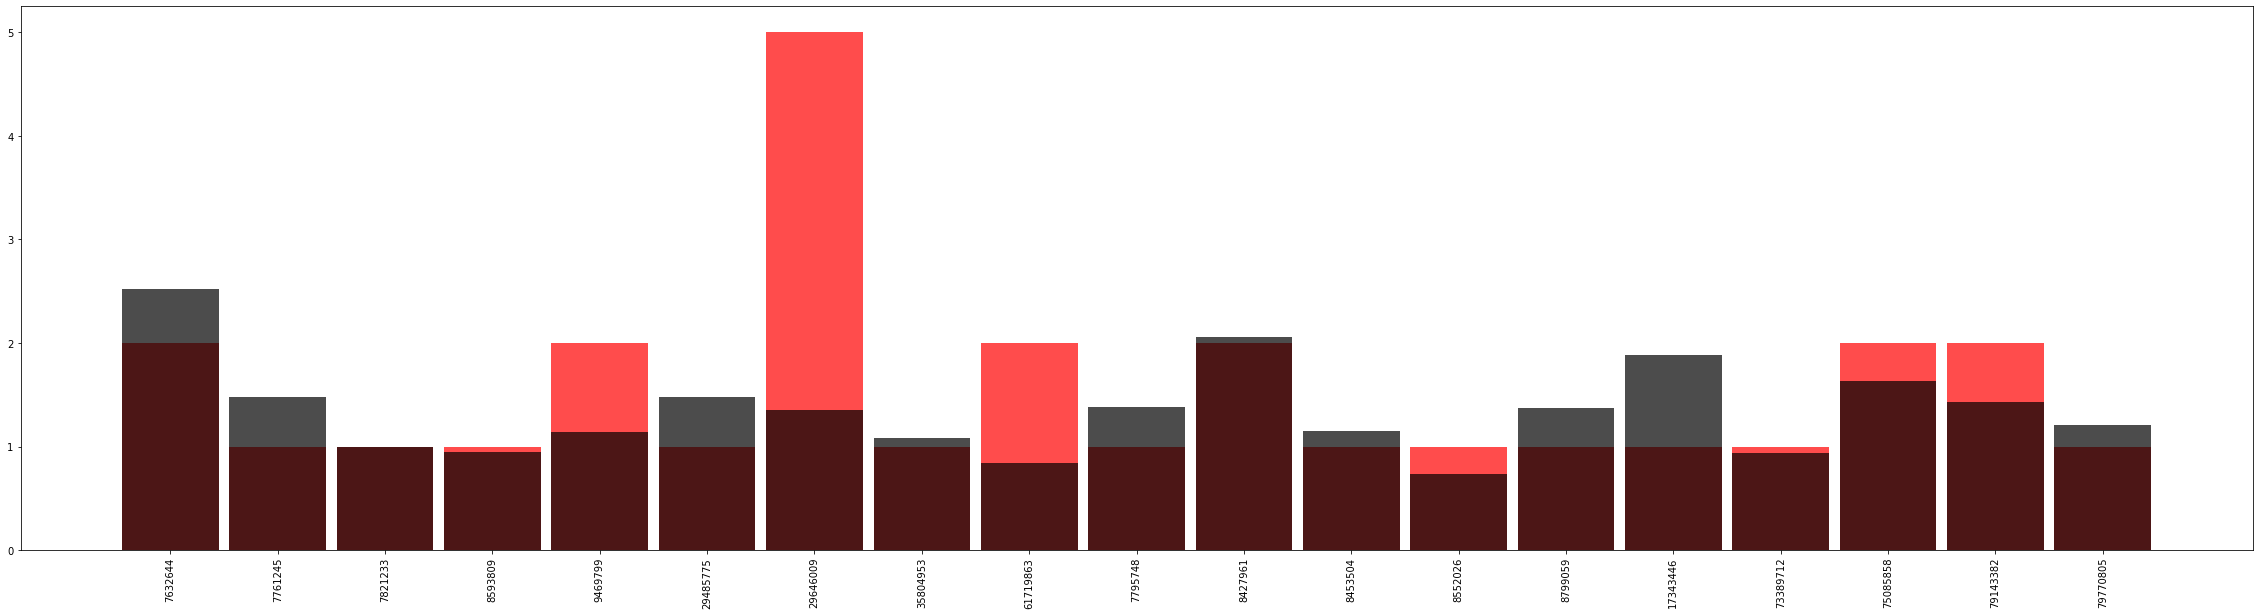

['13120584', '9917812']
[1, 1]
[1.0086783170700073, 0.9408658742904663]


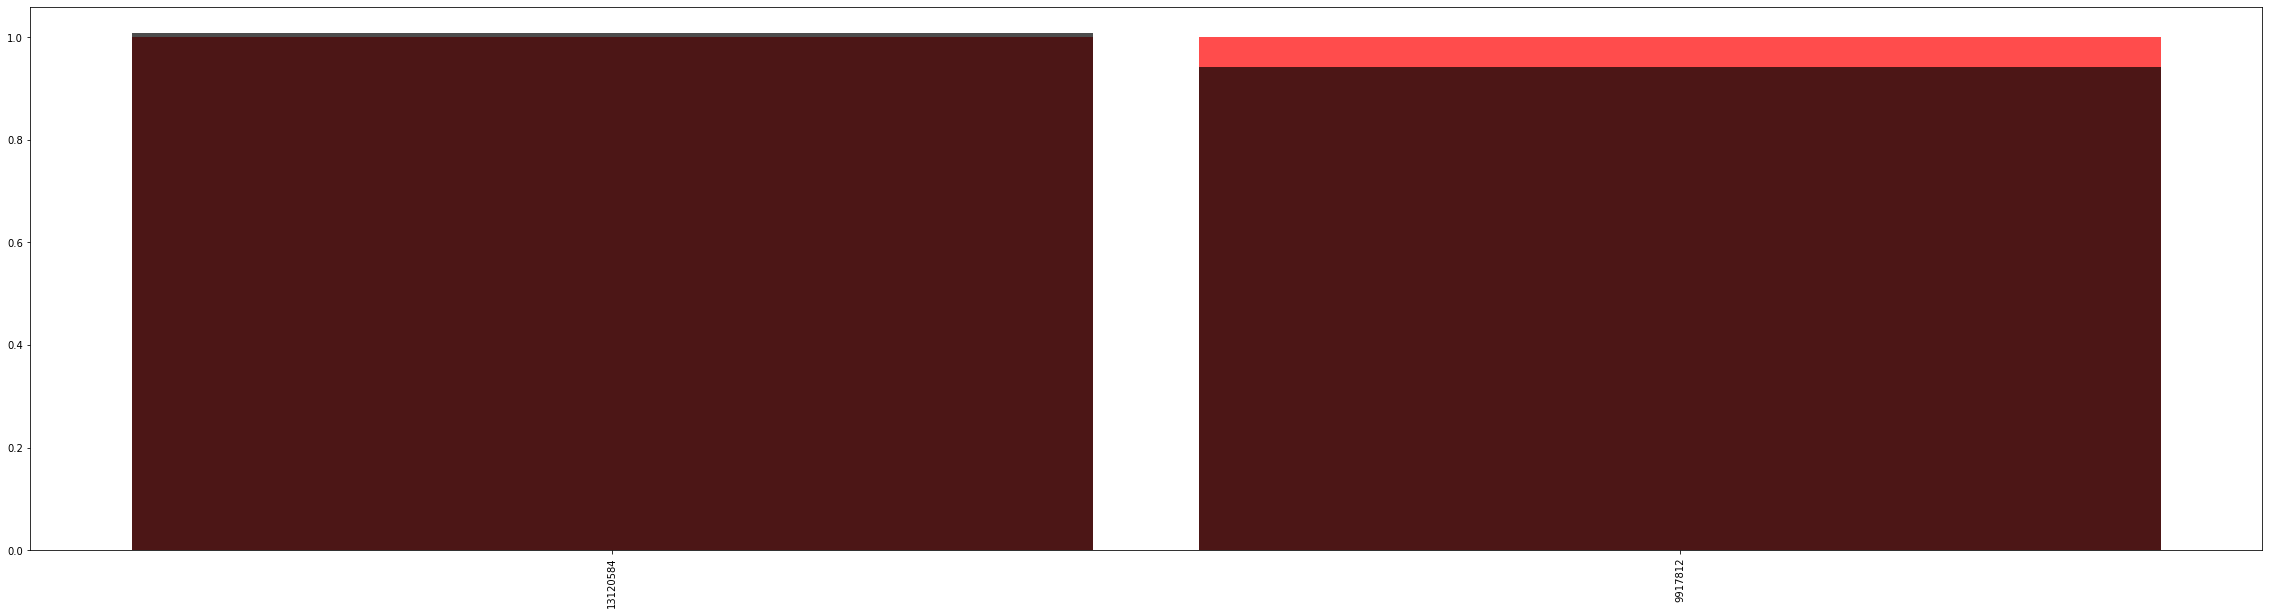

['7632674', '8580707', '8707290', '8787038', '11086409', '27970453', '36363866', '46802726', '66033251', '78774818', '79770805', '7722589', '7757370', '7764975', '7995448', '8728177', '11404719', '11733448', '11745373', '13083052', '13565906', '17842505', '22465780', '22790690', '31547533', '72011273', '90443936']
[4, 1, 1, 1, 3, 1, 1, 1, 1, 2, 2, 1, 1, 1, 14, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1]
[2.8429622650146484, 1.0978491306304932, 1.0493907928466797, 1.344879388809204, 2.094475269317627, 1.885048747062683, 1.489228367805481, 2.2732760906219482, 0.7773791551589966, 0.3756144344806671, 1.6691681146621704, 2.018707036972046, 1.3788363933563232, 2.2081027030944824, 2.6544010639190674, 1.462019920349121, 2.6787054538726807, 0.765146017074585, 1.8053361177444458, 1.7416903972625732, 4.912123203277588, 2.247704267501831, 1.1690788269042969, 0.40208062529563904, 2.340942859649658, 1.3305896520614624, 0.762519896030426]


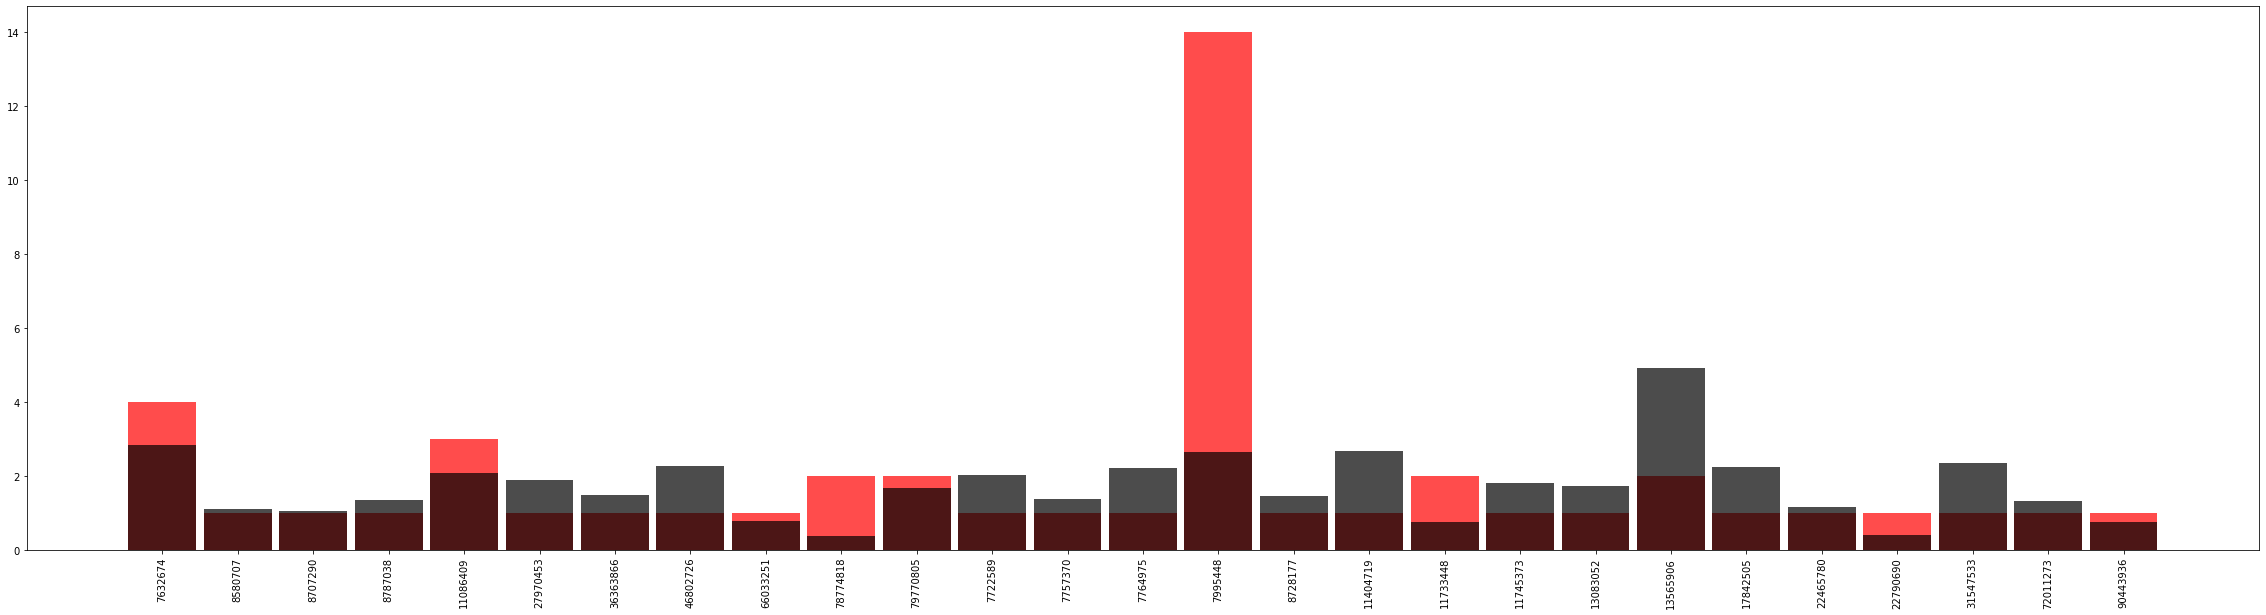

In [ ]:
from matplotlib import pyplot as plt

for camera, prediction_list in camera_predictions:
    size = len(prediction_list)
    labels = [] * size
    real_counts = [] * size
    predicted_counts = [] * size
    for i, x in enumerate(prediction_list):
        final_car_keys = x[0]
        real_count = x[1]
        predicted_count = x[2]
        labels.append(final_car_keys)
        real_counts.append(real_count)
        predicted_counts.append(predicted_count)

    fig = plt.figure(figsize = (40, 10))
    labels = list(map(lambda x: str(x), labels))
    plt.bar(labels, real_counts, width=0.9, color='red', alpha=0.7)
    plt.bar(labels, predicted_counts, width=0.9, color='black', alpha=0.7)
    plt.xticks(rotation='vertical',fontsize=10)
    plt.show()